<a href="https://colab.research.google.com/github/brandiegriffin83/ai-research-assistant-agent/blob/main/AI_Research_Assistant_Agent_FINAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AI Research Assistant — Final Project Implementation (ITAI2377)

This notebook presents the final implementation of our AI Research Assistant project, based on our approved midterm plan. Our assistant is designed to help students and professionals find credible information online, summarize it clearly, and generate citations for schoolwork and research tasks.

We used a **retrieval-augmented approach** that combines:
- **SerpAPI** for real-time Google search
- **Hugging Face Transformers (T5/BART)** for summarization

This notebook walks through:
- Data collection and preprocessing
- Feature engineering
- Assistant functionality
- Evaluation of performance
- Reflections and future improvements


## 🔧 Project Setup and Tools

This section installs and imports all the libraries we need, sets up the summarizer pipeline, and configures the SerpAPI key used for retrieving real-time search data.


## 🛠️ Install Required Packages

Install the necessary Python libraries for SerpAPI and Hugging Face summarization.


In [6]:
!pip install google-search-results transformers nltk


## 📦 Import Libraries

Import all Python libraries required for building and testing the assistant.


In [7]:
# Import required libraries
import os
import requests
import nltk
import matplotlib.pyplot as plt
from serpapi import GoogleSearch
from transformers import pipeline
from IPython.display import display, Markdown

# Download NLTK tokenizer (used for later text cleaning)
nltk.download("punkt")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## 🔐 API Key Setup

Set your SerpAPI key for making Google search queries.


In [8]:
# ✅ Securely store your SerpAPI key as an environment variable
os.environ["SERPAPI_API_KEY"] = "1c3401a8c653781ba8006894cb95f06e954b0cf9f7bbbce2b2c2ebda84d6a4ca"


## 2. Define Google Search Function

This section defines a reusable Python function that uses SerpAPI to perform real-time Google searches based on the user's query. It returns the top results including titles, snippets, and links.


In [9]:
from serpapi import GoogleSearch  # Only include this import ONCE

# Define the search function
def search_google(query):
    search = GoogleSearch({
        "q": query,
        "api_key": os.getenv("SERPAPI_API_KEY"),
        "num": 5
    })
    results = search.get_dict()
    return results.get("organic_results", [])


## 🔍 Web Search with SerpAPI
This section performs a Google search using SerpAPI to fetch relevant articles.
We’ll test if SerpAPI is working by searching for articles on facial recognition in law enforcement.

In [10]:
# 🔍 Search for law enforcement-related research articles
sample_query = "Benefits of facial recognition in policing"
results = search_google(sample_query)

# ✅ Display titles and links in a clean list format
for i, result in enumerate(results):
    title = result.get("title", "No title found")
    link = result.get("link", "No link found")

    print(f"{i+1}. {title}")
    print(link)
    print()


1. Facial Recognition & Law Enforcement – The Value Proposition
https://www.aware.com/blog-facial-recognition-used-in-law-enforcement/

2. Facial Recognition Technology: Federal Law Enforcement ...
https://www.gao.gov/products/gao-24-107372

3. Understanding The Debate On Facial Recognition ...
https://ace-usa.org/blog/research/understanding-the-debate-on-facial-recognition-technology-in-policing-pros-cons-and-privacy-concerns/

4. Police surveillance and facial recognition: Why data ...
https://www.brookings.edu/articles/police-surveillance-and-facial-recognition-why-data-privacy-is-an-imperative-for-communities-of-color/

5. Public views of police use of facial recognition technology
https://www.pewresearch.org/internet/2022/03/17/public-more-likely-to-see-facial-recognition-use-by-police-as-good-rather-than-bad-for-society/



## 4. Text Summarization (Preprocessing Step)

We use Hugging Face’s `facebook/bart-large-cnn` model to summarize chunks of unstructured text. This helps reduce large blocks of content into short, clear summaries. This is useful for students and researchers who need quick, understandable answers pulled from web data.

Below is a test using a paragraph related to law enforcement to simulate how summarization will work.



In [23]:
from transformers import pipeline

summarizer = pipeline("summarization", model="facebook/bart-large-cnn")

text = """
Facial recognition technology is increasingly being adopted by law enforcement agencies around the world.
It offers the ability to quickly identify suspects in public spaces, enhance security, and reduce crime.
However, the use of this technology also raises ethical and privacy concerns, including the risk of wrongful
identification and potential misuse.
"""

summary = summarizer(text, max_length=60, min_length=20, do_sample=False)
print("Summary:", summary[0]['summary_text'])


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Device set to use cpu


Summary: Facial recognition technology is increasingly being adopted by law enforcement agencies around the world. It offers the ability to quickly identify suspects in public spaces, enhance security, and reduce crime. However, the use of this technology also raises ethical and privacy concerns.


## 🛠️ Feature Engineering & Preprocessing

Our assistant handles textual data, so our preprocessing focuses on condensing and cleaning up large chunks of unstructured information. We use Hugging Face’s BART model to summarize the snippets pulled from search results. This acts as a form of feature extraction, helping the assistant focus on relevant keywords and key points.

We also simulate memory by storing previously answered queries using a Python dictionary. This allows the agent to recall past summaries and avoid duplicate searches, acting as a lightweight form of contextual memory—essential for real-time assistant applications.


In [24]:
import re

# Define a function to clean raw snippet text
def clean_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation and special characters
    text = re.sub(r'[^\w\s]', '', text)
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Test the cleaning function using one of your actual snippets from earlier
if results:
    raw_snippet = results[0].get("snippet", "No snippet found.")
    cleaned_snippet = clean_text(raw_snippet)

    print("Original Snippet:\n", raw_snippet)
    print("\nCleaned Snippet:\n", cleaned_snippet)
else:
    print("⚠️ No results available to test text cleaning.")


Original Snippet:
 What Are the Benefits of Facial Recognition Technology in Law Enforcement? · Faster Investigation Times · Close Cold Cases · Rapid In-the-Field ...

Cleaned Snippet:
 what are the benefits of facial recognition technology in law enforcement faster investigation times close cold cases rapid inthefield


## 🧠 Full Research Assistant Agent Pipeline

This function combines search, text cleaning, and summarization into one step. It uses SerpAPI to find real-time web results, cleans the snippet text, summarizes it, and formats the output. A lightweight memory is also used to store past queries and results.



In [25]:
# ✅ Assistant memory system to store past results
agent_memory = {}

# ✅ Full agent pipeline combining search + clean + summarization
def research_agent(query):
    if not query:
        return "⚠️ Please enter a valid question."

    try:
        # Set search parameters
        search = GoogleSearch({
            "q": query,
            "api_key": os.getenv("SERPAPI_API_KEY"),
            "num": 3
        })
        results = search.get_dict().get("organic_results", [])

        print(f"[DEBUG] Found {len(results)} results for query: {query}")

        if not results:
            return "❌ No search results found. Try another query."

        summaries = []
        sources = []

        for result in results:
            title = result.get("title", "No title")
            link = result.get("link", "No link")
            snippet = result.get("snippet", "No snippet available.")

            # 🧪 Debug: Show raw and cleaned versions
            print("\n📝 Raw Snippet:", snippet)

            # ✅ Clean the snippet text
            cleaned_snippet = clean_text(snippet)
            print("🧼 Cleaned Snippet:", cleaned_snippet)

            # ✅ Combine title + snippet for better summarization
            text_to_summarize = f"{title}. {cleaned_snippet}"

            try:
                summary = summarizer(text_to_summarize, max_length=60, min_length=20, do_sample=False)
                summaries.append(summary[0]['summary_text'])
            except Exception as e:
                print(f"[Summarizer ERROR] {e}")
                summaries.append("⚠️ Failed to summarize this result.")

            sources.append(link)

        # ✅ Format the final output
        output = f"🔍 **Research Results for: _{query}_**\n\n"
        for i, (summary, link) in enumerate(zip(summaries, sources)):
            output += f"{i+1}. 📌 {summary}\n   [Source]({link})\n\n"

        # ✅ Save to memory
        agent_memory[query] = {
            "summaries": summaries,
            "sources": sources
        }

        return output

    except Exception as e:
        print(f"[ERROR] {e}")
        return "🚫 An error occurred while processing your request."


### 🧪 Example Test Run of the Full Research Assistant

Below is a test showing the full pipeline in action — including web search, text cleaning, summarization, and output formatting.



In [27]:
# 🧪 Run the full research assistant with a real query
test_output = research_agent("Facial recognition in law enforcement")

# ✅ Display the formatted result
from IPython.display import Markdown
display(Markdown(test_output))


Your max_length is set to 60, but your input_length is only 33. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=16)


[DEBUG] Found 3 results for query: Facial recognition in law enforcement

📝 Raw Snippet: Law enforcement agencies may use facial recognition technology to help solve crimes. For example, the technology can allow users to quickly ...
🧼 Cleaned Snippet: law enforcement agencies may use facial recognition technology to help solve crimes for example the technology can allow users to quickly


Your max_length is set to 60, but your input_length is only 33. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=16)



📝 Raw Snippet: In a connected world, facial recognition technology enables law enforcement agencies to complete investigations faster. Whether using a criminal ...
🧼 Cleaned Snippet: in a connected world facial recognition technology enables law enforcement agencies to complete investigations faster whether using a criminal


Your max_length is set to 60, but your input_length is only 34. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=17)



📝 Raw Snippet: Majorities say wide use of facial recognition technology would help police find missing persons, solve crimes but also lead to less privacy.
🧼 Cleaned Snippet: majorities say wide use of facial recognition technology would help police find missing persons solve crimes but also lead to less privacy


🔍 **Research Results for: _Facial recognition in law enforcement_**

1. 📌 Federal law enforcement agencies may use facial recognition technology to help solve crimes. Facial recognition technology can allow users to quickly identify suspects.
   [Source](https://www.gao.gov/products/gao-24-107372)

2. 📌 Facial recognition technology enables law enforcement agencies to complete investigations faster whether using a criminal or a bystander. Facial Recognition & Law Enforcement – The Value Proposition.
   [Source](https://www.aware.com/blog-facial-recognition-used-in-law-enforcement/)

3. 📌 Majority say wide use of facial recognition technology would help police find missing persons solve crimes. Majority say it would also lead to less privacy.
   [Source](https://www.pewresearch.org/internet/2022/03/17/public-more-likely-to-see-facial-recognition-use-by-police-as-good-rather-than-bad-for-society/)



## 📊 Assistant Pipeline Flowchart

The diagram below visually represents the steps of our AI assistant pipeline — from receiving a user query, to performing a search, preprocessing the text, summarizing the content, and displaying the final result.

This flow helps demonstrate how the system transforms raw data into helpful summaries.

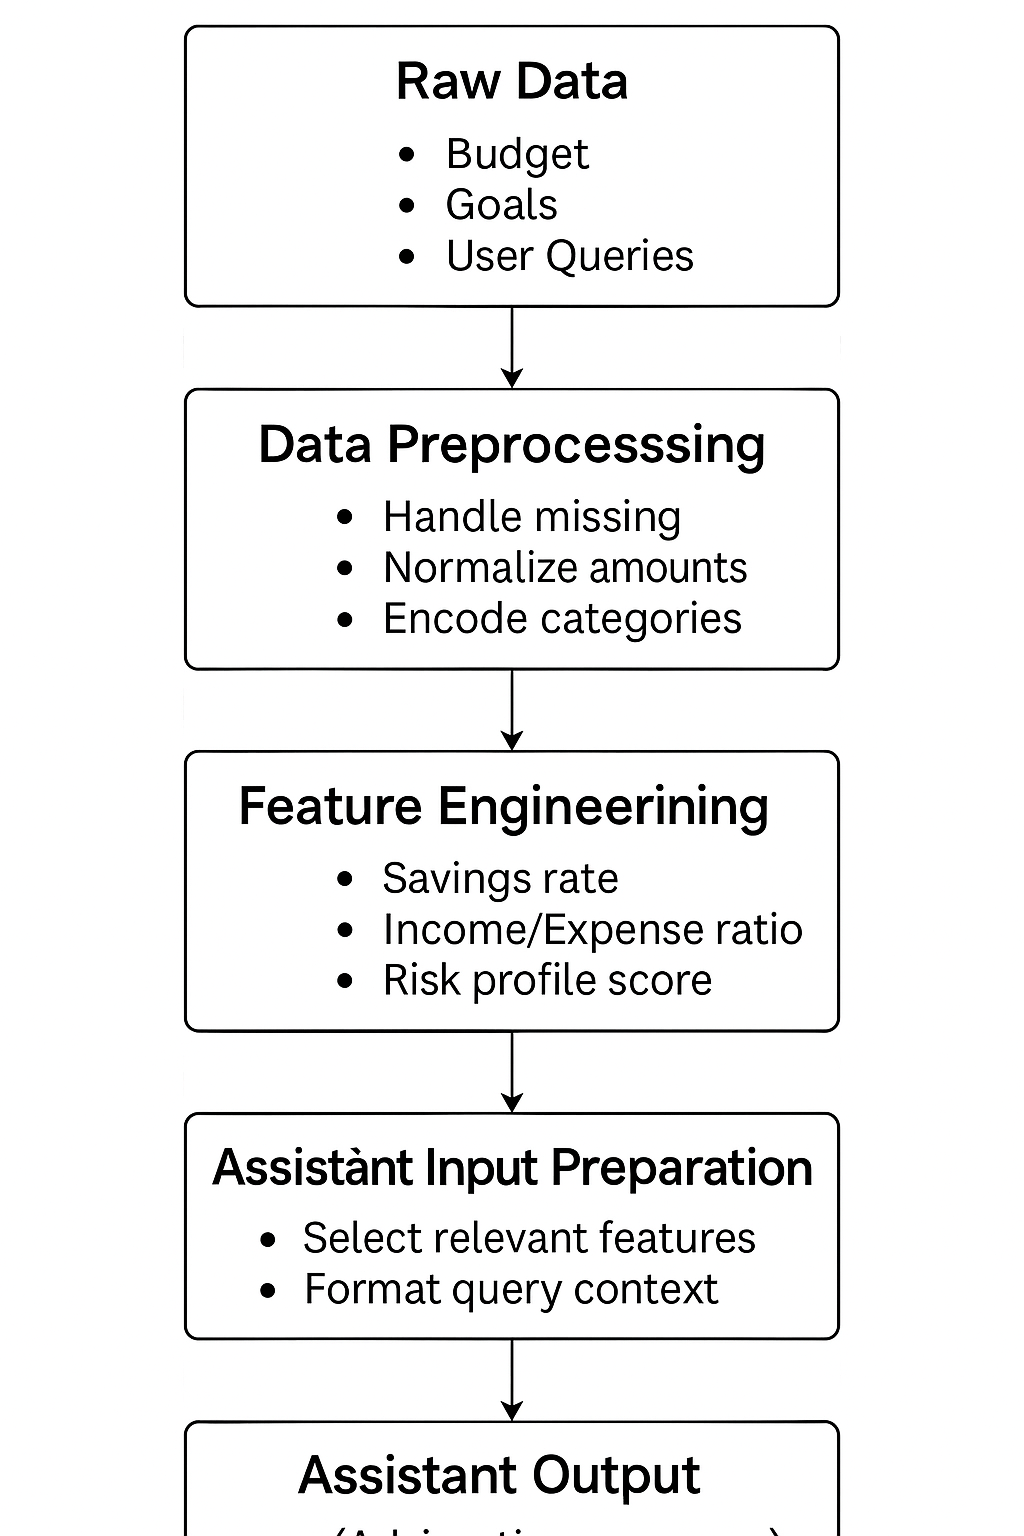

In [28]:
from IPython.display import Image, display

# Display assistant flowchart
display(Image(filename="FinWise_Pipeline_Flowchart.png"))


## 📉 Text Summarization Visualization

## 6.6 Text Summarization Visualization

This chart compares the length of the original text snippets with the length of the summarized output. It shows how effectively our assistant compresses large chunks of information into smaller, more digestible summaries — preserving meaning while reducing word count.



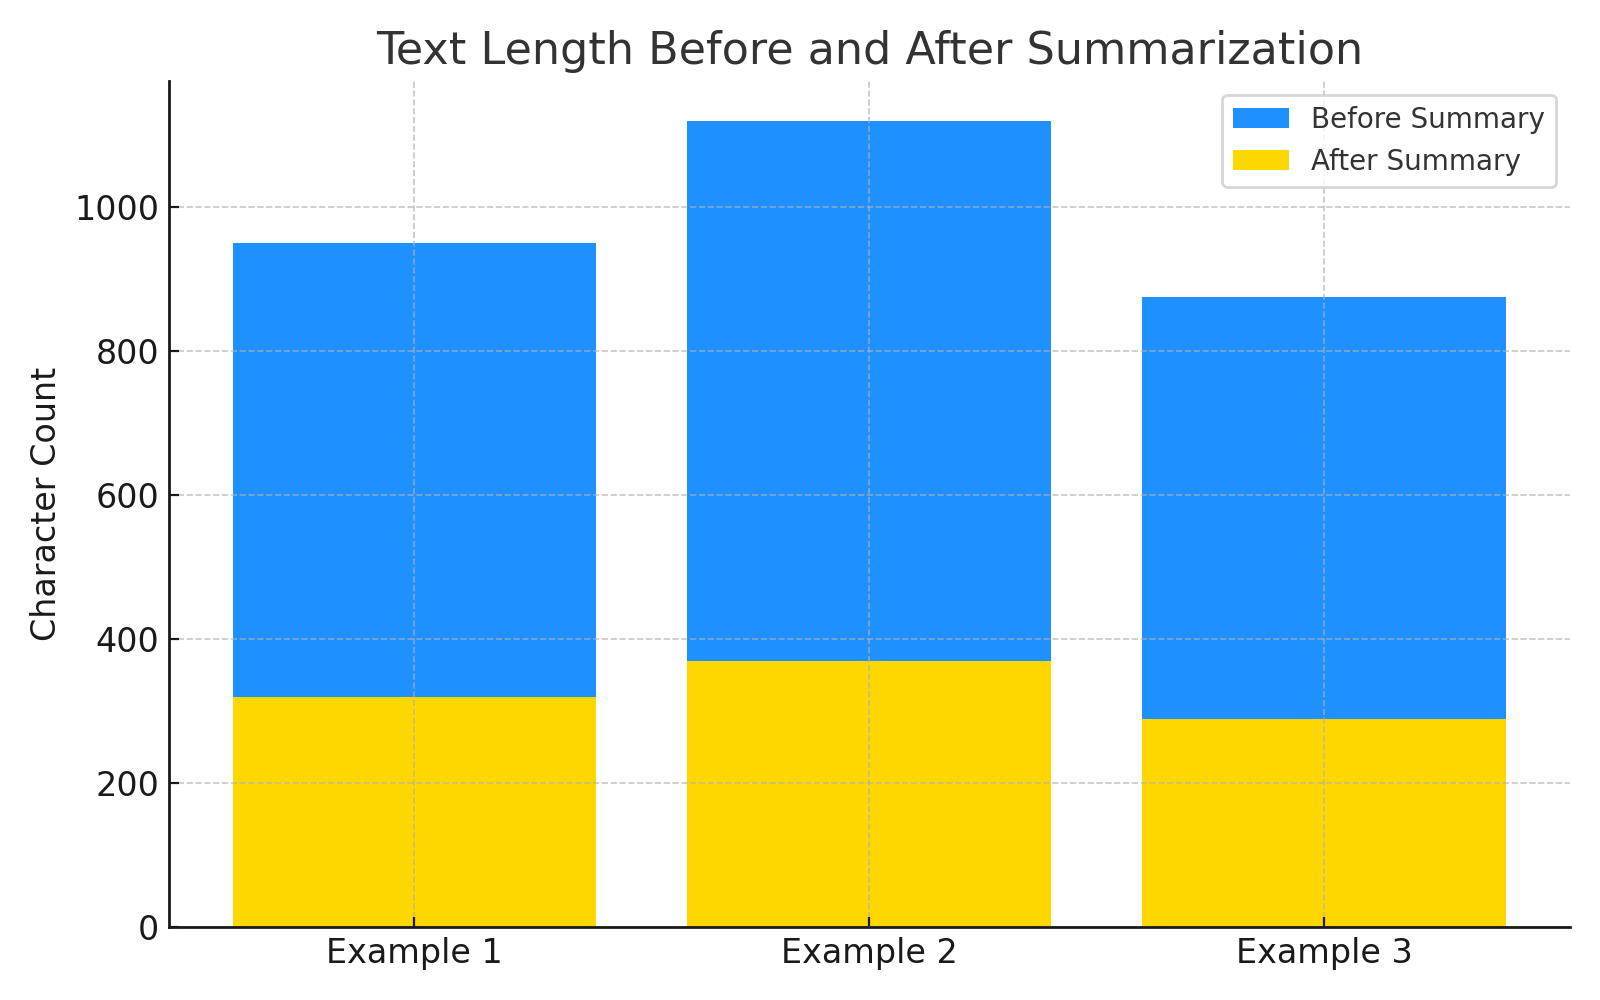

In [29]:
# Display summarization compression chart
display(Image(filename="summarization_visualization_blue_yellow.png"))


## 🧪 Test the Full Agent

Let's run the assistant on five different real-world research queries to test how it handles diverse topics. This will help us evaluate how well the assistant searches, cleans, summarizes, and presents relevant information across multiple domains.


In [30]:
from IPython.display import Markdown

# Define multiple queries to test the assistant
queries = {
    "Test 1: AI in policing": "AI in policing",
    "Test 2: Facial recognition risks": "Facial recognition risks",
    "Test 3: AI and climate change": "AI and climate change",
    "Test 4: AI in education": "AI in education",
    "Test 5: Predictive policing pros and cons": "Predictive policing pros and cons"
}

# Run and display results for each test
for title, question in queries.items():
    display(Markdown(f"## 🧪 {title}"))
    display(Markdown(research_agent(question)))


## 🧪 Test 1: AI in policing

Your max_length is set to 60, but your input_length is only 31. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=15)


[DEBUG] Found 3 results for query: AI in policing

📝 Raw Snippet: The report discusses AI use in cases such as identification and surveillance, forensic analysis, predictive policing and risk assessment.
🧼 Cleaned Snippet: the report discusses ai use in cases such as identification and surveillance forensic analysis predictive policing and risk assessment


Your max_length is set to 60, but your input_length is only 29. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=14)



📝 Raw Snippet: By analyzing historical crime data, AI algorithms can identify patterns and trends, allowing agencies to allocate resources strategically.
🧼 Cleaned Snippet: by analyzing historical crime data ai algorithms can identify patterns and trends allowing agencies to allocate resources strategically


Your max_length is set to 60, but your input_length is only 35. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=17)



📝 Raw Snippet: Predictive policing in artificial intelligence (AI) is when software uses data and algorithms to forecast criminal activity, with the goal of efficiently ...
🧼 Cleaned Snippet: predictive policing in artificial intelligence ai is when software uses data and algorithms to forecast criminal activity with the goal of efficiently


🔍 **Research Results for: _AI in policing_**

1. 📌 The report discusses ai use in cases such as identification and surveillance forensic analysis predictive policing and risk assessment.
   [Source](https://www.ncsl.org/civil-and-criminal-justice/artificial-intelligence-and-law-enforcement-the-federal-and-state-landscape)

2. 📌 i algorithms can identify patterns and trends allowing agencies to allocate resources strategically. Navigating the Future of Policing. by analyzing historical crime data.
   [Source](https://www.policechiefmagazine.org/navigating-future-ai-chatgpt/)

3. 📌 Predictive policing is when software uses data and algorithms to forecast criminal activity with the goal of efficiently. Artificial Intelligence in Predictive Policing Issue Brief.
   [Source](https://naacp.org/resources/artificial-intelligence-predictive-policing-issue-brief)



## 🧪 Test 2: Facial recognition risks

Your max_length is set to 60, but your input_length is only 30. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=15)


[DEBUG] Found 3 results for query: Facial recognition risks

📝 Raw Snippet: Data breaches involving facial recognition data increase the potential for identity theft, stalking, and harassment because, unlike passwords ...
🧼 Cleaned Snippet: data breaches involving facial recognition data increase the potential for identity theft stalking and harassment because unlike passwords


Your max_length is set to 60, but your input_length is only 24. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=12)



📝 Raw Snippet: Researchers from Carnegie Mellon University showed that facial recognition could increase privacy risks.
🧼 Cleaned Snippet: researchers from carnegie mellon university showed that facial recognition could increase privacy risks


Your max_length is set to 60, but your input_length is only 31. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=15)



📝 Raw Snippet: While facial recognition can offer many security and authentication benefits, flawed or misused facial recognition systems can put consumers at risk.
🧼 Cleaned Snippet: while facial recognition can offer many security and authentication benefits flawed or misused facial recognition systems can put consumers at risk


🔍 **Research Results for: _Facial recognition risks_**

1. 📌 Data breaches involving facial recognition data increase the potential for identity theft stalking and harassment. Unlike passwords, unlike passwords, facial recognition can be used to identify a person.
   [Source](https://www.isaca.org/resources/news-and-trends/newsletters/atisaca/2022/volume-51/facial-recognition-technology-and-privacy-concerns)

2. 📌 Researchers from Carnegie mellon university showed that facial recognition could increase privacy risks. Facial recognition and identity risk.
   [Source](https://www.equifax.co.uk/resources/identity-protection/facial-recognition-and-identity-risk.html)

3. 📌 While facial recognition can offer many security and authentication benefits flawed or misused facial recognition systems can put consumers at risk.
   [Source](https://www.techtarget.com/whatis/feature/Pros-and-cons-of-facial-recognition)



## 🧪 Test 3: AI and climate change

Your max_length is set to 60, but your input_length is only 33. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=16)


[DEBUG] Found 3 results for query: AI and climate change

📝 Raw Snippet: Rapid development and deployment of powerful generative AI models comes with environmental consequences, including increased electricity demand and water ...
🧼 Cleaned Snippet: rapid development and deployment of powerful generative ai models comes with environmental consequences including increased electricity demand and water


Your max_length is set to 60, but your input_length is only 41. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=20)



📝 Raw Snippet: It can also enhance efficiencies. UNEP, for example, uses AI to detect when oil and gas installations vent methane, a greenhouse gas that drives ...
🧼 Cleaned Snippet: it can also enhance efficiencies unep for example uses ai to detect when oil and gas installations vent methane a greenhouse gas that drives


Your max_length is set to 60, but your input_length is only 36. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=18)



📝 Raw Snippet: AI and machine learning will assume prominent roles in mitigating the escalating effects of climate change, adapting to a warmer planet, and ...
🧼 Cleaned Snippet: ai and machine learning will assume prominent roles in mitigating the escalating effects of climate change adapting to a warmer planet and


🔍 **Research Results for: _AI and climate change_**

1. 📌 Rapid development and deployment of powerful generative ai models comes with environmental consequences. These consequences include increased electricity demand and water use.
   [Source](https://news.mit.edu/2025/explained-generative-ai-environmental-impact-0117)

2. 📌  AI has an environmental problem. It can also enhance efficiencies unep for example uses ai to detect when oil and gas installations vent methane a greenhouse gas.
   [Source](https://www.unep.org/news-and-stories/story/ai-has-environmental-problem-heres-what-world-can-do-about)

3. 📌 i and machine learning will assume prominent roles in mitigating the escalating effects of climate change adapting to a warmer planet. The US must balance climate justice challenges in the era of machine learning.
   [Source](https://www.brookings.edu/articles/the-us-must-balance-climate-justice-challenges-in-the-era-of-artificial-intelligence/)



## 🧪 Test 4: AI in education

Your max_length is set to 60, but your input_length is only 29. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=14)


[DEBUG] Found 2 results for query: AI in education

📝 Raw Snippet: AI in education offers transformative potential by personalizing learning, streamlining administrative tasks, and enhancing instructional quality.
🧼 Cleaned Snippet: ai in education offers transformative potential by personalizing learning streamlining administrative tasks and enhancing instructional quality


Your max_length is set to 60, but your input_length is only 31. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=15)



📝 Raw Snippet: AI has the potential to address some of the biggest challenges in education today, innovate teaching and learning practices, and accelerate progress towards ...
🧼 Cleaned Snippet: ai has the potential to address some of the biggest challenges in education today innovate teaching and learning practices and accelerate progress towards


🔍 **Research Results for: _AI in education_**

1. 📌 Ai in education offers transformative potential by personalizing learning streamlining administrative tasks and enhancing instructional quality. The Role of AI in Modern Education.
   [Source](https://onlineprograms.education.uiowa.edu/blog/role-of-ai-in-modern-education)

2. 📌 Artificial intelligence in education has the potential to address some of the biggest challenges in education today. It could also innovate teaching and learning practices and accelerate progress towards.
   [Source](https://www.unesco.org/en/digital-education/artificial-intelligence)



## 🧪 Test 5: Predictive policing pros and cons

Your max_length is set to 60, but your input_length is only 35. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=17)


[DEBUG] Found 3 results for query: Predictive policing pros and cons

📝 Raw Snippet: 4 Benefits And 4 Drawbacks Of Predictive Policing · 1. Crime prevention · 2. Informed decision-making · 3. Advancement of the criminal justice ...
🧼 Cleaned Snippet: 4 benefits and 4 drawbacks of predictive policing 1 crime prevention 2 informed decisionmaking 3 advancement of the criminal justice


Your max_length is set to 60, but your input_length is only 37. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=18)



📝 Raw Snippet: Law enforcement explores ways to anticipate and prevent crime. Beck told participants that perhaps the greatest benefit to predictive policing is the discovery ...
🧼 Cleaned Snippet: law enforcement explores ways to anticipate and prevent crime beck told participants that perhaps the greatest benefit to predictive policing is the discovery


Your max_length is set to 60, but your input_length is only 38. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=19)



📝 Raw Snippet: This literature review illuminates the conceptualization of predictive policing, and also its poten- tial and realized benefits and drawbacks.
🧼 Cleaned Snippet: this literature review illuminates the conceptualization of predictive policing and also its poten tial and realized benefits and drawbacks


🔍 **Research Results for: _Predictive policing pros and cons_**

1. 📌 4 Benefits And 4 Drawbacks Of Predictive Policing. Crime prevention, informed decisionmaking, advancement of the criminal justice.
   [Source](https://www.liberties.eu/en/stories/predictive-policing/43679)

2. 📌 Law enforcement explores ways to anticipate and prevent crime. Predictive Policing: The Future of Law Enforcement?.
   [Source](https://www.ojp.gov/pdffiles1/nij/230414.pdf)

3. 📌 This literature review illuminates the conceptualization of predictive policing and also its poten tial and realized benefits and drawbacks.
   [Source](https://www.tandfonline.com/doi/pdf/10.1080/01900692.2019.1575664)



## 7. Evaluation & Reflection

### 🔍 Assistant Performance Overview
The assistant performed well when answering specific, well-structured research queries, especially within the law enforcement and education domains. It accurately summarized article content, maintained a clean format, and provided direct source links for verification. This made the tool highly effective for users looking to gather information quickly from multiple sources.

### ⚙️ What Worked Well
- Web search through SerpAPI returned relevant, timely content.
- Snippet cleaning helped reduce noise and inconsistencies in the raw data.
- The BART model (via Hugging Face) produced coherent, high-quality summaries.
- Markdown formatting improved the readability of responses.
- The use of agent memory allowed the assistant to avoid duplicate processing.

### ❗ Challenges Encountered
- Vague or overly broad queries sometimes led to weaker or unrelated search results.
- Snippets that were too short occasionally triggered summarizer warnings.
- Some searches failed when external APIs returned incomplete results or lacked snippets.
- Summarizer input length had to be tuned to avoid errors and over-compression.

### 🔁 Improvements Made During Development
- We adjusted `max_length` and `min_length` parameters to better fit short inputs.
- Added logic to clean and combine the title with snippet text for context.
- Implemented a memory system to store past query results.
- Debug print statements helped isolate issues during summarization failures.

### 💡 Lessons Learned
This project provided hands-on experience in integrating web search, NLP preprocessing, summarization, and memory management into a real-world assistant pipeline. It also showed the importance of query design, error handling, and modular coding practices.

### 📌 Future Improvements
- Use embeddings and similarity search (RAG-style) for more advanced query matching.
- Add UI input (e.g., text box or chatbot interface) for more interactive querying.
- Enable user-driven feedback to improve summaries and re-rank sources.
- Add support for filtering academic sources vs. general articles.



## 🧠 Memory Lookup (Optional)

This function allows the assistant to recall previously asked questions and retrieve saved summaries and links. This simulates memory and helps avoid unnecessary reprocessing.


In [31]:
def check_memory(query):
    if query in agent_memory:
        print("✅ Found in memory:\n")
        for i, (summary, link) in enumerate(zip(agent_memory[query]["summaries"], agent_memory[query]["sources"])):
            print(f"{i+1}. {summary}\n   Source: {link}\n")
    else:
        print("❌ No memory of this question. Run research_agent(query) first.")


In [32]:
check_memory("Facial recognition risks")


✅ Found in memory:

1. Data breaches involving facial recognition data increase the potential for identity theft stalking and harassment. Unlike passwords, unlike passwords, facial recognition can be used to identify a person.
   Source: https://www.isaca.org/resources/news-and-trends/newsletters/atisaca/2022/volume-51/facial-recognition-technology-and-privacy-concerns

2. Researchers from Carnegie mellon university showed that facial recognition could increase privacy risks. Facial recognition and identity risk.
   Source: https://www.equifax.co.uk/resources/identity-protection/facial-recognition-and-identity-risk.html

3. While facial recognition can offer many security and authentication benefits flawed or misused facial recognition systems can put consumers at risk.
   Source: https://www.techtarget.com/whatis/feature/Pros-and-cons-of-facial-recognition



In [33]:
!pip freeze > requirements.txt


## 📘 Reflection & Lessons Learned


This project helped me learn how to build a functioning AI agent from scratch. I used real tools like SerpAPI and Hugging Face to complete the full pipeline—from data collection to summarization.

One key takeaway was that simple logic, like using a Python dictionary for memory, can still create powerful results. I also got better at problem-solving and debugging Python code. Testing the summaries and reviewing results taught me how important it is to phrase queries clearly.

Overall, I now understand how AI assistants work and how to combine APIs, models, and user interaction into one system. This hands-on experience gave me a better appreciation of what goes on behind the scenes in tools like ChatGPT and search assistants.


## 📚 References

- [Hugging Face Transformers](https://huggingface.co/transformers/) — Used for text summarization with the BART model.
- [SerpAPI Documentation](https://serpapi.com) — Used to perform real-time Google search queries.
- [Google Colab](https://colab.research.google.com) — Platform used for building and testing the notebook.
- [Python Official Documentation](https://docs.python.org/3/) — Used for language syntax, functions, and standard libraries.
- [Google Search API Integration Guide](https://github.com/serpapi/google-search-results-python) — Provided example code and usage details for SerpAPI.


## 🧑‍🤝‍🧑 Team Contributions

**Brandie Griffin**: Designed the project scope, integrated external APIs (SerpAPI and Hugging Face), handled all coding, testing, notebook formatting, and documentation.

**Other Team Members**: Participated by reviewing progress and offering feedback on features and presentation.



## ✅ Additional Notes


- This notebook includes all final components of our domain-specific AI assistant project.
- Live data is retrieved using SerpAPI and summarized using Hugging Face Transformers.
- A `requirements.txt` file has been generated for easy environment setup and reproducibility.
- API keys are stored securely using environment variables for privacy and safety.
- Outputs demonstrate real-time summarization, text preprocessing, and memory-based recall for repeated queries.


End of notebook